<a href="https://colab.research.google.com/github/locdacknownothing/QReCC_EDA_Feature_Extraction/blob/main/Assignment_2_Analyse_data_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Analyse and visualize QReCC dataset

## 1. The QReCC dataset description

* The **QReCC (Question Rewriting in Conversational Context)** dataset is an open-domain question answering dataset, containing **14000 conversations** with a total of **81000 question-answer pairs**.
* The text in dataset is collected from these source:
  - QuAC (Question Answering in Context): the questions and answers are based on contextual information derived from preceding dialogue turns.
  - TREC CAsT (Conversational Assistance Track): developed by TREC (Text REtrieval Conference) to support research in conversational information retrieval.
  - Natural Questions: the real user queries and their corresponding answers, usually derived from Wikipedia articles.
* It serves as a comprehensive benchmark for developing and evaluating end-to-end conversational question answering systems, covering tasks like question rewriting, passage retrieval, and reading comprehension.
* In QReCC, the objective is to retrieve answers for conversational questions from a massive collection of **10 million web pages** which are segmented into **54 million passages**. Since answers to questions within a single conversation may be found across different web pages, the dataset challenges models to effectively gather information from multiple sources to provide coherent responses.
* The downloaded dataset has 2 splits:
  - Train: **63501** samples
  - Test: **16451** samples


## 2. Import libraries

In [6]:
! pip install -U datasets wordcloud transformers nltk -q

In [7]:
from pathlib import Path

from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import torch
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel, pipeline

In [5]:
dataset = load_dataset("voidful/qrecc")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


qrecc_train.json:   0%|          | 0.00/66.6M [00:00<?, ?B/s]

qrecc_test.json:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/63501 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/16451 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Question', 'Turn_no', 'Answer', 'Context', 'Answer_URL', 'Rewrite', 'Conversation_no', 'Conversation_source'],
        num_rows: 63501
    })
    test: Dataset({
        features: ['Question', 'Turn_no', 'Answer', 'Context', 'Answer_URL', 'Rewrite', 'Conversation_no', 'Conversation_source'],
        num_rows: 16451
    })
})

## 3. QReCC train set

In [8]:
train_data = pd.DataFrame(dataset["train"])
train_data.head()

,Question,Turn_no,Answer,Context,Answer_URL,Rewrite,Conversation_no,Conversation_source
0,What can you tell me about Gary Cherone?,1,Gary Francis Caine Cherone is an American rock...,[],https://en.wikipedia.org/wiki/Van_Halen,What can you tell me about Gary Cherone?,1,quac
1,Did Gary sing well?,2,"Yes, Gary Cherone is also known for his work a...","[What can you tell me about Gary Cherone?, Gar...",https://en.wikipedia.org/wiki/Van_Halen,Did Gary Cherone sing well?,1,quac
2,What significant fact can you tell me about Ga...,3,I like that Gary Cherone remained in contact a...,"[What can you tell me about Gary Cherone?, Gar...",https://en.wikipedia.org/wiki/Van_Halen,What significant fact can you tell me about Ga...,1,quac
3,What did Cherone do after Van Halen?,4,"After his departure from Van Halen, Gary Chero...","[What can you tell me about Gary Cherone?, Gar...",https://en.wikipedia.org/wiki/Van_Halen,What did Gary Cherone do after Van Halen?,1,quac
4,Did they release any albums during that time f...,5,"After Gary Cherone, Eddie Van Halen recovered ...","[What can you tell me about Gary Cherone?, Gar...",https://en.wikipedia.org/wiki/Van_Halen,Did they release any albums after Gary Cherone...,1,quac


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63501 entries, 0 to 63500
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Question             63501 non-null  object
 1   Turn_no              63501 non-null  int64 
 2   Answer               63501 non-null  object
 3   Context              63501 non-null  object
 4   Answer_URL           63501 non-null  object
 5   Rewrite              63501 non-null  object
 6   Conversation_no      63501 non-null  int64 
 7   Conversation_source  63501 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.9+ MB


The dataset doesn't have empty cell.
We then filter just necessary columns and re-arrange the order of them.


In [10]:
pd.reset_option('display.max_colwidth')

train_data = train_data[[
  "Conversation_source",
  "Conversation_no",
  "Turn_no",
  "Context",
  "Question",
  "Rewrite",
  "Answer",
]]
train_data.tail()

,Conversation_source,Conversation_no,Turn_no,Context,Question,Rewrite,Answer
63496,nq,10823,1,[],Where does Call of the Dead take place,Where does Call of the Dead take place,It takes place in a desolate area of the Siber...
63497,nq,10823,2,"[Where does Call of the Dead take place, It ta...",What is the theme,What is Call ForThe Dead's theme,The players are once again are tasked with sur...
63498,nq,10823,3,"[Where does Call of the Dead take place, It ta...",What is the genre,What is the genre of Call For The Dead,"The genre is crime, spy novel."
63499,nq,10823,4,"[Where does Call of the Dead take place, It ta...",Who plays the main role,Who plays the main role in Call For The Dead,Simon Russell Beale plays the main role ij Cal...
63500,nq,10823,5,"[Where does Call of the Dead take place, It ta...",Who is the author,Who is the author of Call For The Dead,David John Moore Cornwell (born 19 October 193...


### 3.1. The distribution of conversation sources

In [11]:
train_data["Conversation_source"].describe()

,Conversation_source
count,63501
unique,2
top,quac
freq,50360


In [12]:
def plot_pie_chart(data: pd.Series, title: str):
    counts = data.value_counts()
    plt.figure(figsize=(5, 5))
    counts.plot(kind="pie", autopct="%1.2f%%", startangle=90)
    plt.title(title)
    plt.ylabel(None)  # Remove y-label for pie chart
    plt.show()

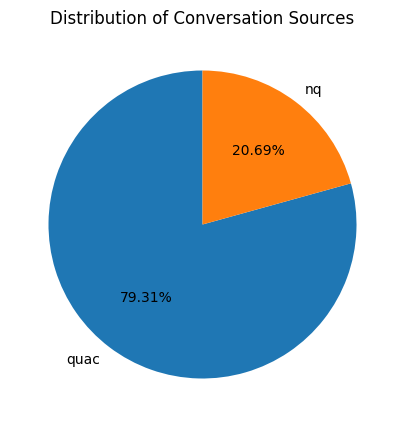

In [13]:
plot_pie_chart(train_data["Conversation_source"], "Distribution of Conversation Sources")

### 3.2. The number of turns per conversation

In [14]:
turns_per_conversation = train_data.groupby('Conversation_no')['Turn_no'].max()
turns_per_conversation.describe()

,Turn_no
count,10823.000000
mean,6.008223
std,2.586666
min,1.000000
25%,5.000000
50%,5.000000
75%,8.000000
max,12.000000


In [15]:
def plot_bar_chart(
    data: pd.Series,
    title: str,
    xlabel: str,
    ylabel: str,
    rotation: float = 0,
    figsize: tuple = (10, 5)
):
    counts = data.value_counts().sort_index()
    plt.figure(figsize=figsize)
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.show()

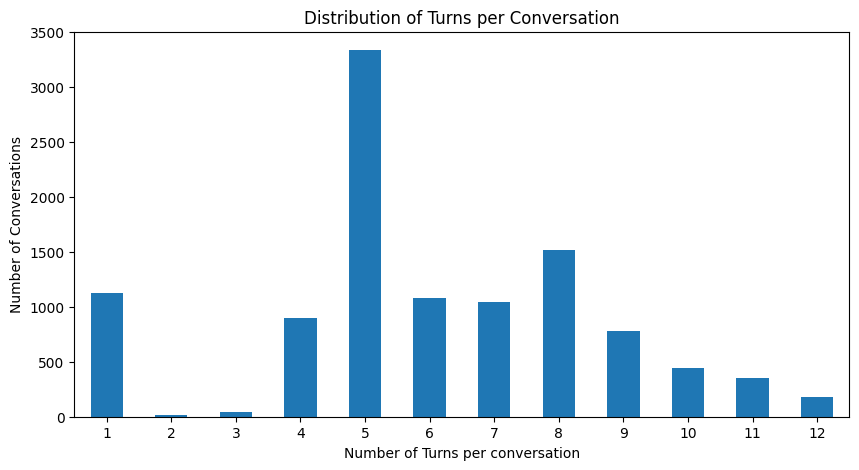

In [16]:
plot_bar_chart(
    turns_per_conversation,
    "Distribution of Turns per Conversation",
    "Number of Turns per conversation",
    "Number of Conversations",
)

### 3.3. Context

The **Context** column is structured as a list of strings, where each string typically represents a previous utterance in the conversation leading up to the current question.

In [17]:
contexts = train_data["Context"]
contexts[3]

['What can you tell me about Gary Cherone?',
 'Gary Francis Caine Cherone is an American rock singer and songwriter, known for his work as the lead vocalist of Extreme and for his short stint for Van Halen.',
 'Did Gary Cherone sing well?',
 'Yes, Gary Cherone is also known for his work as the lead vocalist of the Boston rock group Extreme.',
 'What significant fact can you tell me about Gary Cherone that you liked?',
 'I like that Gary Cherone remained in contact and on good terms with Van Halen.']

#### 3.3.1. The total number of words in context

In [18]:
def plot_histogram(
    data: pd.Series,
    title: str,
    xlabel: str,
    ylabel: str,
    figsize: tuple = (10, 5),
    bins: int = 40,
    edgecolor: str = "black"
):
    plt.figure(figsize=figsize)
    data.hist(bins=bins, edgecolor=edgecolor)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(False)
    plt.show()

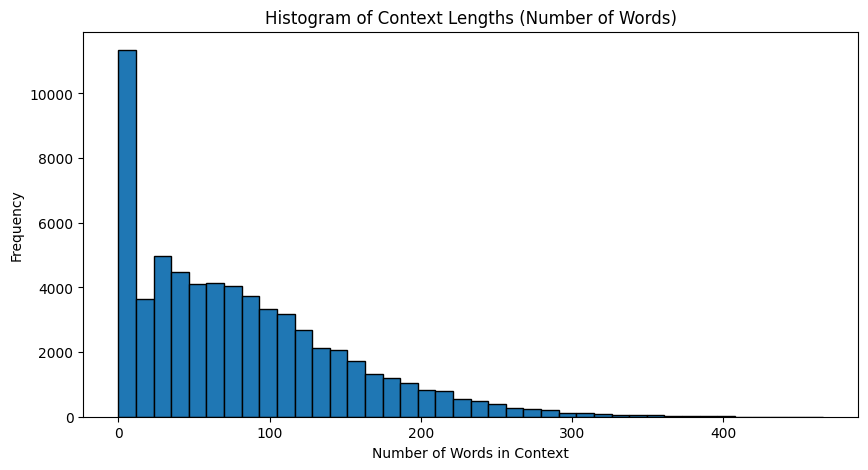

In [19]:
train_data["Context_Length"] = train_data["Context"].apply(lambda x: sum(len(s.split()) for s in x))
plot_histogram(
    train_data["Context_Length"],
    "Histogram of Context Lengths (Number of Words)",
    "Number of Words in Context",
    "Frequency"
)

In [20]:
pd.set_option('display.max_colwidth', None)

outlier_context = train_data[train_data["Context_Length"] > 300]["Context"]
outlier_context.head()

,Context
88,"[Where was Sara Evans born?, Sara Evans was born in Boonville, Missouri, in 1971, and is of Welsh, English, Irish, and Native American descent., Was Sara Evans raised there?, Sara Evans was raised on a farm near New Franklin, Missouri, the eldest girl of seven children., Did Sara Evans get an education in music?, Sara Evans attended Central Methodist for 11 days despite getting a full ride scholarship to a school with a good music department. She was to study music at this university., When did Sara Evans become an artist?, Sara Evans moved to Nashville, Tennessee, in 1991 to be a country music artist., When did Sara Evans rise to fame?, In 1995, Sara Evans began recording demos. Nashville songwriter Harlan Howard was impressed by her demo. He decided to help her music career, leading to a contract with RCA Nashville., What were some of Sara Evans's early songs?, Although none of its singles (True Lies, the title track, and Shame About That) reached the Billboard Hot Country Songs chart, the album received praise for its neotraditional country sound., Did any of Sara Evans's songs reach any charts or billboards?, No Place That Far's second single and title track, gave Sara Evans her first Number One hit on the Hot Country Songs chart in March 1999., Was Sara Evans married early in her career?, Sara Evans moved to Nashville, Tennessee, in 1991. She met fellow musician Craig Schelske and left Nashville with him in 1992, moving to Oregon. They married in 1993., Are there any other interesting aspects about this article?, While Sara Evans's' debut album was defined by neotraditionalist country influences, most of her material has taken a more slick, country pop production, similar to Faith Hill and Martina McBride., Was Sara Evans badly hurt in this accident?, At the age of eight, Sara Evans was struck by an automobile, and her legs suffered multiple fractures. Recuperating for months, she continued singing to help pay her medical bills.]"
89,"[Where was Sara Evans born?, Sara Evans was born in Boonville, Missouri, in 1971, and is of Welsh, English, Irish, and Native American descent., Was Sara Evans raised there?, Sara Evans was raised on a farm near New Franklin, Missouri, the eldest girl of seven children., Did Sara Evans get an education in music?, Sara Evans attended Central Methodist for 11 days despite getting a full ride scholarship to a school with a good music department. She was to study music at this university., When did Sara Evans become an artist?, Sara Evans moved to Nashville, Tennessee, in 1991 to be a country music artist., When did Sara Evans rise to fame?, In 1995, Sara Evans began recording demos. Nashville songwriter Harlan Howard was impressed by her demo. He decided to help her music career, leading to a contract with RCA Nashville., What were some of Sara Evans's early songs?, Although none of its singles (True Lies, the title track, and Shame About That) reached the Billboard Hot Country Songs chart, the album received praise for its neotraditional country sound., Did any of Sara Evans's songs reach any charts or billboards?, No Place That Far's second single and title track, gave Sara Evans her first Number One hit on the Hot Country Songs chart in March 1999., Was Sara Evans married early in her career?, Sara Evans moved to Nashville, Tennessee, in 1991. She met fellow musician Craig Schelske and left Nashville with him in 1992, moving to Oregon. They married in 1993., Are there any other interesting aspects about this article?, While Sara Evans's' debut album was defined by neotraditionalist country influences, most of her material has taken a more slick, country pop production, similar to Faith Hill and Martina McBride., Was Sara Evans badly hurt in this accident?, At the age of eight, Sara Evans was struck by an automobile, and her legs suffered multiple fractures. Recuperating for months, she continued singing to help pay her medical bills., Did Sara Evans still sing during this time?,

#### 3.3.2. The correlation of the number of words in context and answer

In [21]:
def plot_heatmap(
    data: pd.DataFrame,
    title: str,
    xlabel: str,
    ylabel: str,
    figsize: tuple = (10, 5),
):
    plt.figure(figsize=figsize)
    sns.heatmap(data, annot=True, fmt="g", cbar_kws={"label": "Number of Samples"})
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

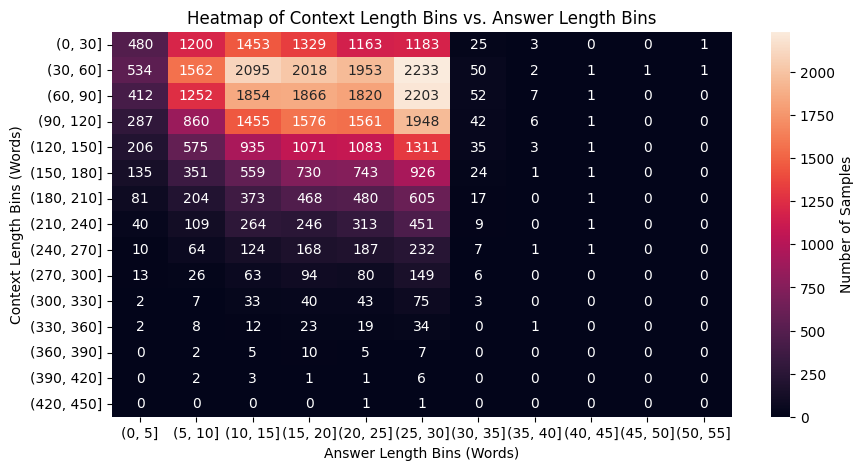

In [22]:
train_data["Answer_Length"] = train_data["Answer"].apply(lambda x: len(x.split()))

context_bins = range(0, train_data["Context_Length"].max() + 1, 30)  # Bins for context lengths (0-100 words)
answer_bins = range(0, train_data["Answer_Length"].max(), 5)      # Bins for answer lengths (0-50 words)

train_data["Context_Binned"] = pd.cut(train_data["Context_Length"], bins=context_bins)
train_data["Answer_Binned"] = pd.cut(train_data["Answer_Length"], bins=answer_bins)

frequency_table = pd.crosstab(train_data["Context_Binned"], train_data["Answer_Binned"])

plot_heatmap(
    frequency_table,
    "Heatmap of Context Length Bins vs. Answer Length Bins",
    "Answer Length Bins (Words)",
    "Context Length Bins (Words)",
)

### 3.4. Question

In [23]:
train_data["Question"].head()

,Question
0,What can you tell me about Gary Cherone?
1,Did Gary sing well?
2,What significant fact can you tell me about Gary that you liked?
3,What did Cherone do after Van Halen?
4,Did they release any albums during that time frame?


#### 3.4.1. The number of words in question

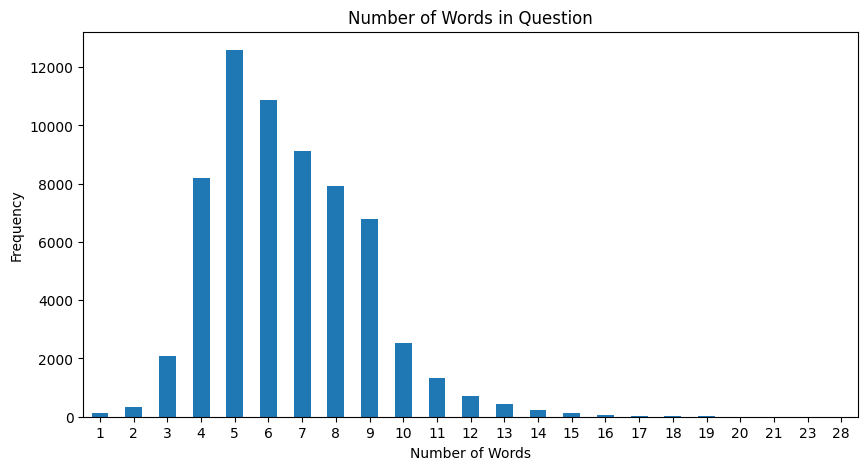

In [24]:
train_data["Question_Length"] = train_data["Question"].apply(lambda x: len(x.split()))

plot_bar_chart(
    train_data["Question_Length"],
    "Number of Words in Question",
    "Number of Words",
    "Frequency"
)

In [25]:
outlier = train_data[train_data["Question_Length"] > 15]["Question"]
outlier.head()

,Question
1101,What one thing that they did more controversial that was the final straw for the CBS censors?
1711,Can you provide me with a little information about Walter Winterbottom and his career as an England Team Manager?
2347,DidDoes That Blue Moon Ever Shine On You was not a commercial success--did it chart at all?
2839,Did he have a bad relationship with someone that caused him to announce his retirement in 2004?
3437,Did he purchase the team by himself with his own money or did he have partners?


#### 3.4.2. Word cloud of question

In [26]:
def plot_word_cloud(text: str, title: str):
  wordcloud = WordCloud(width=1000, height=500).generate(text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(title)
  plt.show()

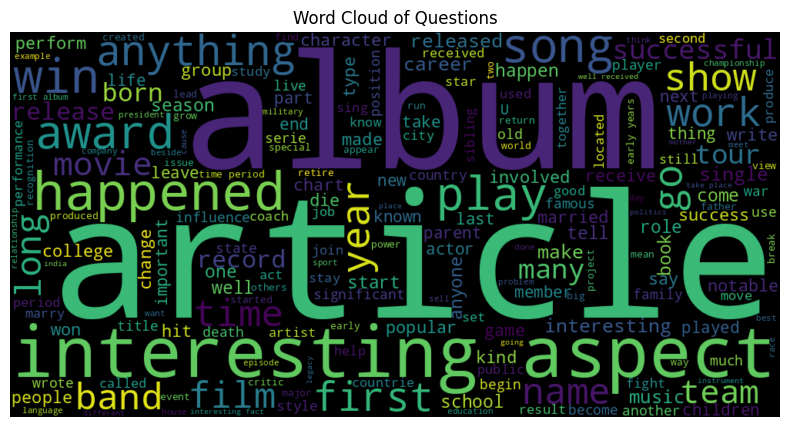

In [27]:
text = " ".join(train_data["Question"])
plot_word_cloud(text, "Word Cloud of Questions")

#### 3.4.3. Difference in the number of words between Question vs. Rewrite

In [28]:
train_data["Rewrite_Length"] = train_data["Rewrite"].apply(lambda x: len(x.split()))
train_data["Length_Difference"] = (train_data["Question_Length"] - train_data["Rewrite_Length"]).abs()

length_differences = train_data["Length_Difference"].value_counts()
length_differences.head()

,count
Length_Difference,
1,17324
0,9747
2,7363
3,6262
4,5258


In [29]:
def plot_line_chart(data: pd.Series, title: str, xlabel: str, ylabel: str):
  data = data.sort_index()
  plt.figure(figsize=(10, 5))
  plt.plot(data.index, data, marker="o", markersize=2, linestyle="-", alpha=0.7)

  plt.title("Distribution of Difference in the Number of Words between Questions and Rewrites")
  plt.xticks(rotation=0)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

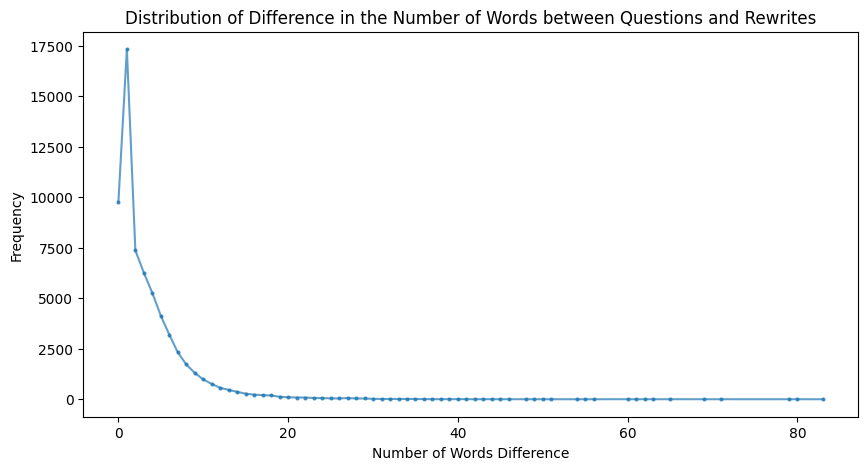

In [30]:
plot_line_chart(
    length_differences,
    "Distribution of Difference in the Number of Words between Questions and Rewrites",
    "Number of Words Difference",
    "Frequency"
)

#### 3.4.4. The number of words in Question and Answer

---



In [31]:
def plot_scatter(x: pd.Series, y: pd.Series, title: str, xlabel: str, ylabel: str):
  plt.figure(figsize=(10, 5))
  plt.scatter(x, y, alpha=0.5)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(True)
  plt.show()

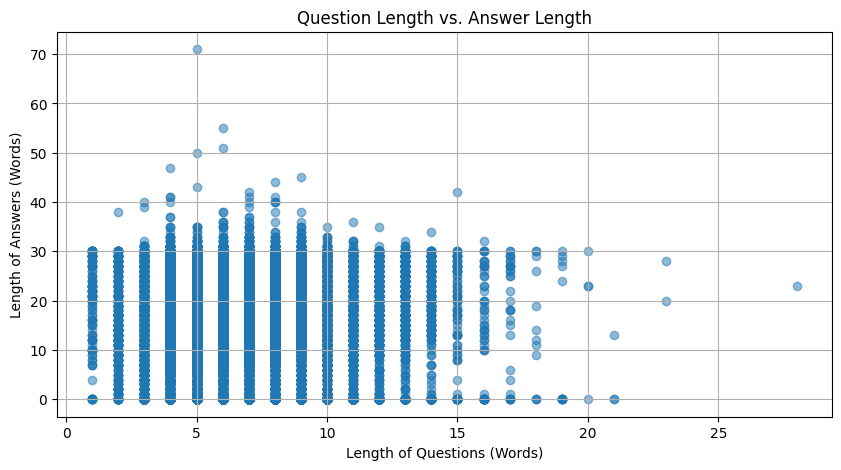

In [32]:
train_data["Question_Length"] = train_data["Question"].apply(lambda x: len(x.split()))
train_data["Answer_Length"] = train_data["Answer"].apply(lambda x: len(x.split()))

plot_scatter(
    train_data["Question_Length"],
    train_data["Answer_Length"],
    "Question Length vs. Answer Length",
    "Length of Questions (Words)",
    "Length of Answers (Words)"
)

### 3.5. Answer

#### 3.5.1. The number of words in answer

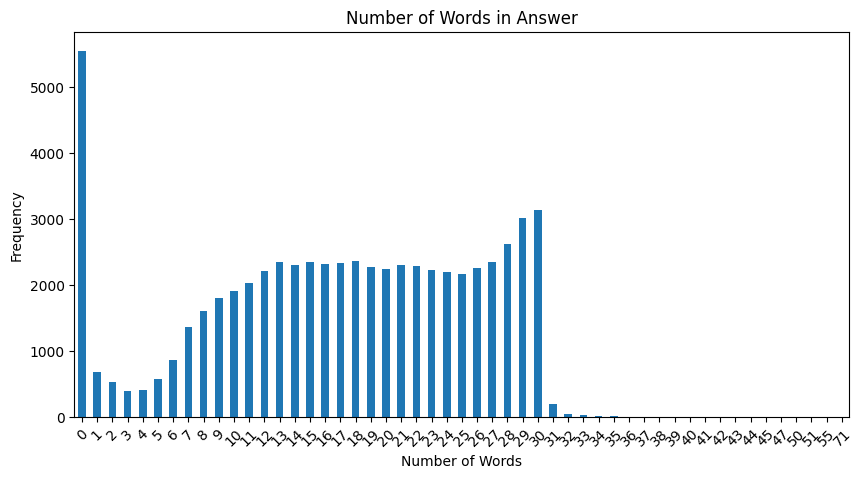

In [33]:
plot_bar_chart(
    train_data["Answer_Length"],
    "Number of Words in Answer",
    "Number of Words",
    "Frequency",
    rotation=45,
)

In [34]:
outlier_answer = train_data[train_data["Answer_Length"] > 35]["Answer"]
outlier_answer

,Answer
1268,"David Robinson is one of only a very small group of players to have scored over 20,000 career points in the NBA, as well as being one of only four players to have recorded a quadruple-double"
2354,"Horses has since been viewed by critics as one of the greatest and most influential albums not only in the history of the American punk rock movement, but also in the history of all rock and roll."
4098,"Strong's output dropped off in 1932 as he moved to the fullback position. He appeared in 11 games and ranked sixth in the NFL with 375 rushing yards, but scored only 15 points on two touchdowns and three extra points."
6139,"Liuzzo so passionately believed in the fight for civil rights that she helped organize Detroit protests, attended civil rights conferences and worked with the NAACP. She had a strong desire to make a difference on as large a scale as she could."
8700,"The original New York Dolls lineup initially was composed of singer David Johansen, guitarists Johnny Thunders and Rick Rivets (who was replaced by Sylvain Sylvain after a few months), bass guitarist Arthur Killer Kane and drummer Billy Murcia."
13027,"In Apology, Socrates is presented as mentioning Plato by name as one of those youths close enough to him to have been corrupted and questioning why their fathers and brothers did not step forward to testify against him if he was indeed guilty of such a crime."
13080,"The senior manager advised Woodward on June 19 that E. Howard Hunt, who had ties to Nixon, was involved; the telephone number of his White House office had been listed in the address book of one of the burglars."
13196,"Traditional examples for Turkish folk literature include stories of Karagöz and Hacivat, İncili Çavuş and Nasreddin Hoca, as well as the works of folk poets such as Yunus Emre. Keloğlan, İncili Çavuş and Nasreddin Hoca, as well as the works of folk poets such as Yunus Emre and Aşık Veysel."
13428,"Some of the supporters of his these include Maurice Gaudefroy-Demombynes, who rights that many ahadith, are apocryphal and were invented in the 8th century in order to justify innovations and tendencies which were very foreign to the intentions of the Prophet.“"
13432,"Of the diplomatic stalemate in the Israeli-Palestinian peace process, Lapid said, Most of the blame belongs to the Palestinian side, and I am not sure that they as a people are ready to make peace with us.“"


#### 3.5.2. Word cloud of question

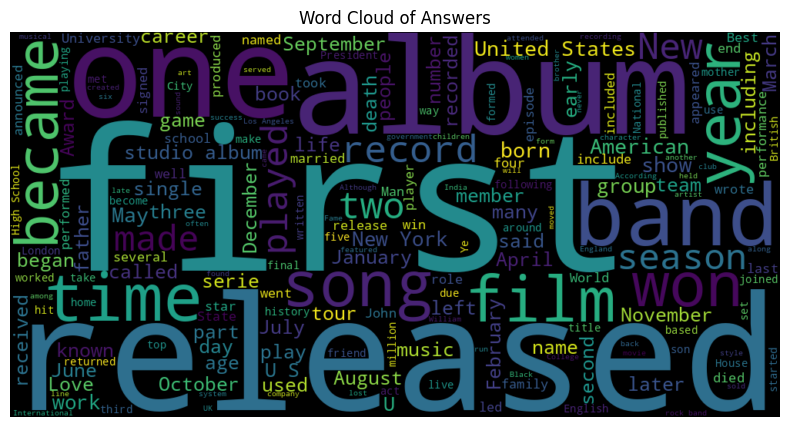

In [35]:
text = " ".join(train_data["Answer"])
plot_word_cloud(text, "Word Cloud of Answers")

## 4. QReCC test set

In [36]:
pd.reset_option('display.max_colwidth')

test_data = pd.DataFrame(dataset["test"])
test_data.head()

,Question,Turn_no,Answer,Context,Answer_URL,Rewrite,Conversation_no,Conversation_source
0,What is a physician's assistant?,1,physician assistants are medical providers who...,[],https://explorehealthcareers.org/career/medici...,What is a physician's assistant?,1,trec
1,What are the educational requirements required...,2,Complete your bachelor's degree (a science or ...,"[What is a physician's assistant?, physician a...",https://www.geteducated.com/careers/how-to-bec...,What are the educational requirements required...,1,trec
2,What does it cost?,3,Average Cost Across all PA Schools for the 201...,"[What is a physician's assistant?, physician a...",https://www.thepalife.com/how-much-does-it-cos...,What does it cost to become a physician's assi...,1,trec
3,What's the average starting salary in the UK?,4,Typical starting salaries for physician associ...,"[What is a physician's assistant?, physician a...",https://www.prospects.ac.uk/job-profiles/physi...,What's the average starting salary for a physi...,1,trec
4,What about in the US?,5,An early career Physician Assistant (PA) with ...,"[What is a physician's assistant?, physician a...",https://www.payscale.com/research/US/Job=Physi...,What's the average starting salary for a physi...,1,trec


In [37]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16451 entries, 0 to 16450
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Question             16451 non-null  object
 1   Turn_no              16451 non-null  int64 
 2   Answer               16451 non-null  object
 3   Context              16451 non-null  object
 4   Answer_URL           16451 non-null  object
 5   Rewrite              16451 non-null  object
 6   Conversation_no      16451 non-null  int64 
 7   Conversation_source  16451 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.0+ MB


The dataset doesn't have empty cell.
We then filter just necessary columns and re-arrange the order of them.


In [38]:
test_data = test_data[[
  "Conversation_source",
  "Conversation_no",
  "Turn_no",
  "Context",
  "Question",
  "Rewrite",
  "Answer",
]]
test_data.tail()

,Conversation_source,Conversation_no,Turn_no,Context,Question,Rewrite,Answer
16446,nq,2773,3,[When did the 21st edition of the Commonwealth...,Has the event always been known by that name,Has the event always been known by Commonwealt...,Commonwealth Games called first the British Em...
16447,nq,2773,4,[When did the 21st edition of the Commonwealth...,How many countries have hosted the event,How many countries have hosted the Commonwealt...,Nineteen cities in nine countries counting Eng...
16448,nq,2773,5,[When did the 21st edition of the Commonwealth...,What country will hold the next,What country will the next Commonwealth Games ...,The next Commonwealth Games are to be held in ...
16449,nq,2774,1,[],What is the difference between pka and pi,What is the difference between pka and pi,The pKa is found on a titration curve where mi...
16450,nq,2775,1,[],england's involvement in the 30 years war,england's involvement in the 30 years war,


### 4.1. The distribution of conversation sources

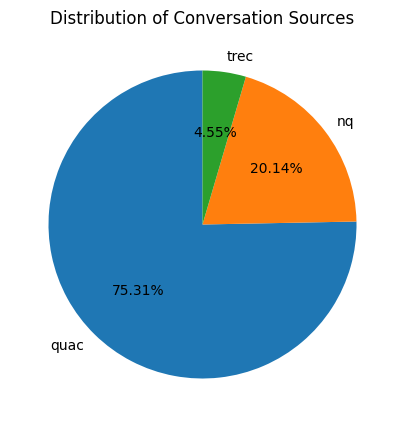

In [39]:
plot_pie_chart(
    test_data["Conversation_source"],
    "Distribution of Conversation Sources"
)

### 4.2. The number of turns per conversation

In [40]:
turns_per_conversation = test_data.groupby('Conversation_no')['Turn_no'].max()
turns_per_conversation.describe()

,Turn_no
count,2775.000000
mean,6.050450
std,2.581263
min,1.000000
25%,5.000000
50%,6.000000
75%,8.000000
max,12.000000


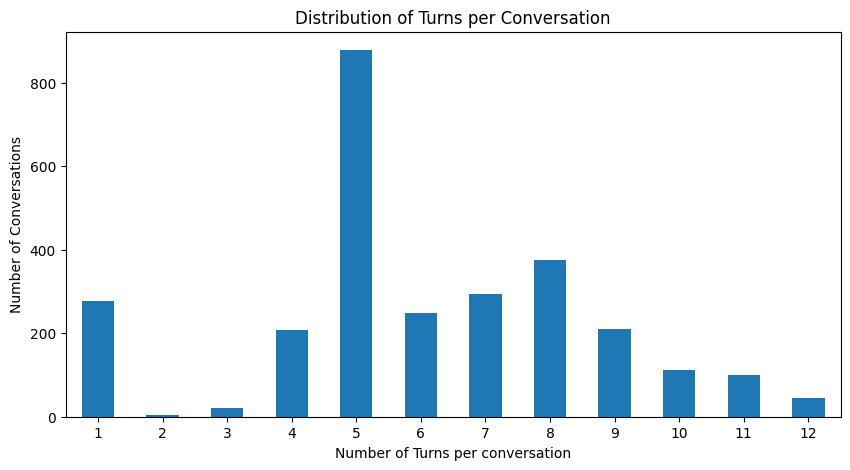

In [41]:
plot_bar_chart(
    turns_per_conversation,
    "Distribution of Turns per Conversation",
    "Number of Turns per conversation",
    "Number of Conversations",
)

### 4.3. Context

In [42]:
contexts = test_data["Context"]
contexts[3]

["What is a physician's assistant?",
 'physician assistants are medical providers who are licensed to diagnose and treat illness and disease and to prescribe medication for patients',
 "What are the educational requirements required to become a physician's assistant?",
 "Complete your bachelor's degree (a science or healthcare related major is usually best); Gain experience either working or volunteering in a healthcare setting; Apply to ARC-PA accredited physician assistant programs; Complete a 2-3 year, master's level PA program;",
 "What does it cost to become a physician's assistant?",
 'Average Cost Across all PA Schools for the 2017 Application Cycle is as Follows: Average cost of resident tuition for a 27-month physician assistant program is: $71,369. Average cost of non-resident tuition for a 27-month physician assistant program is: $89,975.']

#### 4.3.1. The total number of words in context

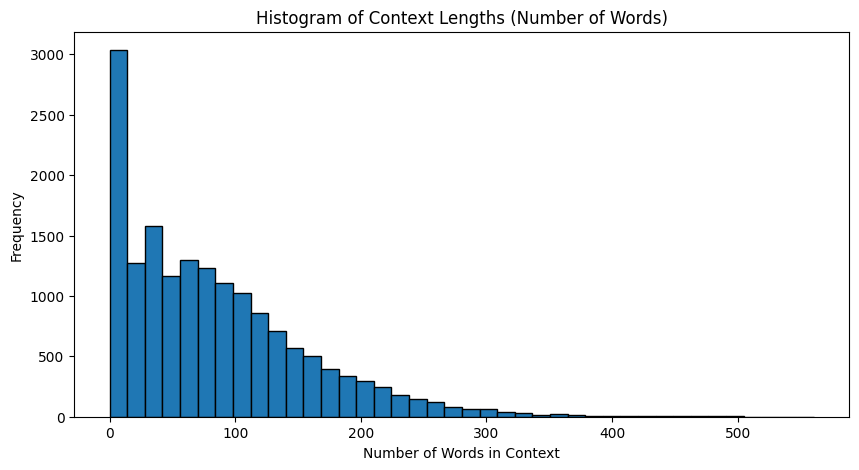

In [43]:
test_data["Context_Length"] = test_data["Context"].apply(lambda x: sum(len(s.split()) for s in x))
plot_histogram(
    test_data["Context_Length"],
    "Histogram of Context Lengths (Number of Words)",
    "Number of Words in Context",
    "Frequency"
)

#### 4.3.2. The correlation of the number of words in context and answer

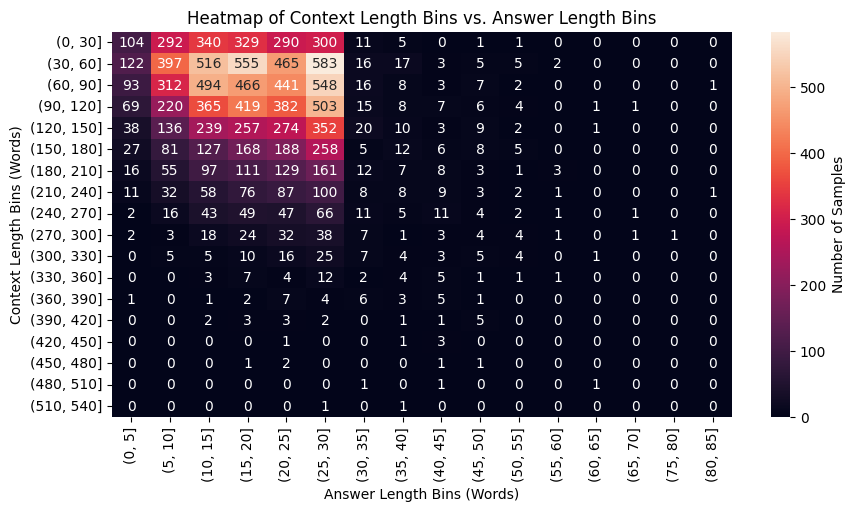

In [44]:
test_data["Answer_Length"] = test_data["Answer"].apply(lambda x: len(x.split()))

context_bins = range(0, test_data["Context_Length"].max() + 1, 30)  # Bins for context lengths (0-100 words)
answer_bins = range(0, test_data["Answer_Length"].max(), 5)      # Bins for answer lengths (0-50 words)

test_data["Context_Binned"] = pd.cut(test_data["Context_Length"], bins=context_bins)
test_data["Answer_Binned"] = pd.cut(test_data["Answer_Length"], bins=answer_bins)

frequency_table = pd.crosstab(test_data["Context_Binned"], test_data["Answer_Binned"])
plot_heatmap(
    frequency_table,
    "Heatmap of Context Length Bins vs. Answer Length Bins",
    "Answer Length Bins (Words)",
    "Context Length Bins (Words)",
)

### 4.4. Question

#### 4.4.1. The number of words in question

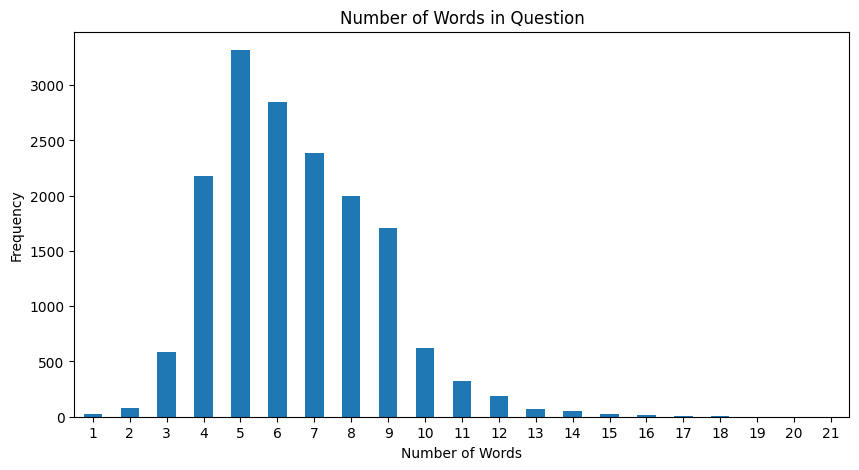

In [45]:
test_data["Question_Length"] = test_data["Question"].apply(lambda x: len(x.split()))
plot_bar_chart(
    test_data["Question_Length"],
    "Number of Words in Question",
    "Number of Words",
    "Frequency"
)

In [46]:
pd.set_option('display.max_colwidth', None)

outlier_question = test_data[test_data["Question_Length"] > 15]["Question"]
outlier_question

,Question
1184,Did they stay with the same record label with this success or they had somebody new?
1406,What is the name of a project that David Marks worked on in his Post-Beach Boys career?
1890,Was there a reason why he decided to do a nude scene since it's so uncommon?
2681,What were the CompuStats on the fight with Nunez i.e what % of his hits landed?
4203,What do critics have to say about her acting in film and on hangin with Mr. Cooper?
5822,Did the Colts get to play in any championship games (like the Super Bowl) during this season?
6214,Do you know why he didn't play in the Wold Championships and his last appearance was in August?
6304,It may have smelled a bit fishy but where were the Backstreet Boys' first gig at?
6868,Were there any other notable figures that worked with Richard III on the Court of Requests?
6876,I think there are 7 games in the world series itself. How many did they win during puckets first world series


#### 4.4.2. Word cloud of question

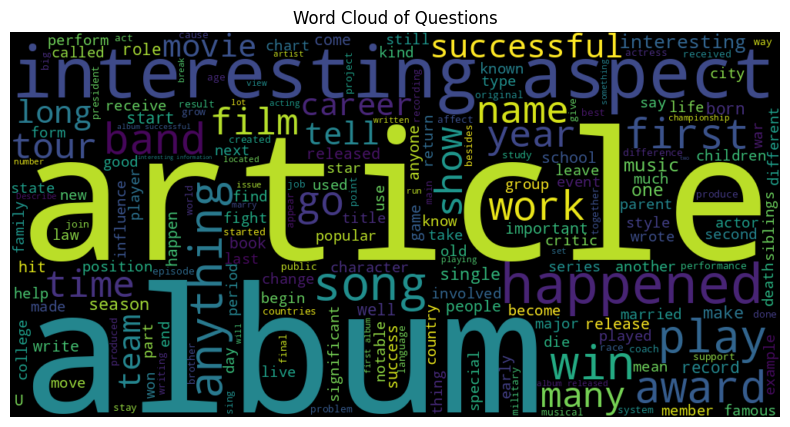

In [47]:
text = " ".join(test_data["Question"])
plot_word_cloud(text, "Word Cloud of Questions")

#### 4.4.3. Difference in the number of words between Question vs. Rewrite

In [48]:
test_data["Rewrite_Length"] = test_data["Rewrite"].apply(lambda x: len(x.split()))
test_data["Length_Difference"] = (test_data["Question_Length"] - test_data["Rewrite_Length"]).abs()

length_differences = test_data["Length_Difference"].value_counts()
length_differences.head()

,count
Length_Difference,
1,4389
0,2676
2,2003
3,1647
4,1348


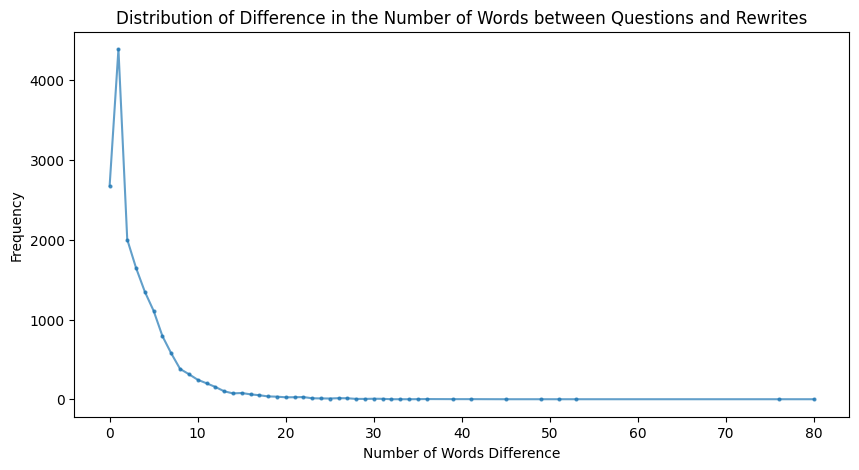

In [49]:
plot_line_chart(
    length_differences,
    "Distribution of Difference in the Number of Words between Questions and Rewrites",
    "Number of Words Difference",
    "Frequency"
)

#### 4.4.4. The number of words in Question and Answer

---



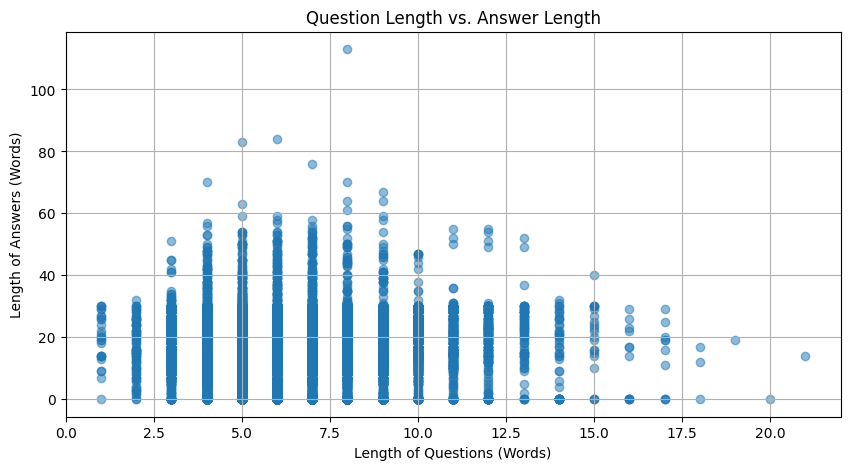

In [50]:
test_data["Question_Length"] = test_data["Question"].apply(lambda x: len(x.split()))
test_data["Answer_Length"] = test_data["Answer"].apply(lambda x: len(x.split()))

plot_scatter(
    test_data["Question_Length"],
    test_data["Answer_Length"],
    "Question Length vs. Answer Length",
    "Length of Questions (Words)",
    "Length of Answers (Words)"
)

### 4.5. Answer

#### 4.5.1. The number of words in answer

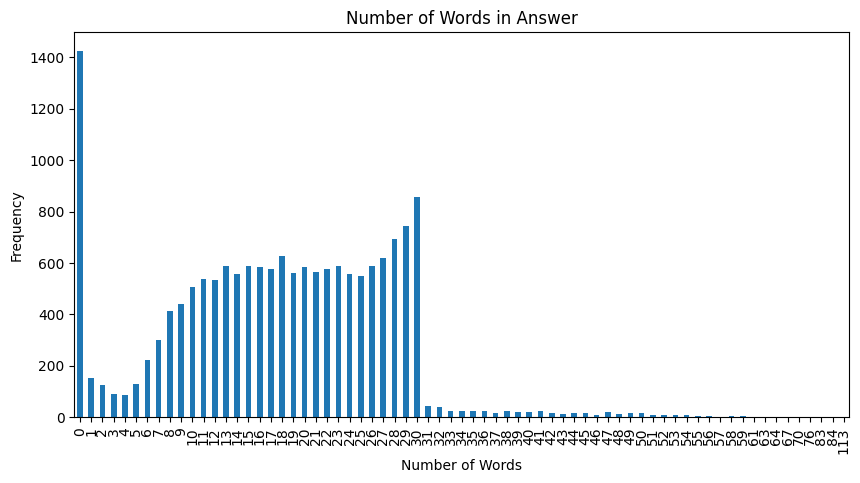

In [51]:
plot_bar_chart(
    test_data["Answer_Length"],
    "Number of Words in Answer",
    "Number of Words",
    "Frequency",
    rotation=90,
)

In [52]:
outlier_answer = test_data[test_data["Answer_Length"] > 59]["Answer"]
outlier_answer

,Answer
249,"Replacing incandescent and CFL bulbs with LED lights, using reusable cloth bag to carry grocery and other items, commuting via public transport, utilizing both sides of paper to write or to print, reusing and recycling goods, spending less time under shower, watering plants early morning or at dusk to limit evaporation, harvesting rain water, switching to solar power, etc are some of those measures."
252,"A 2009 study of the relationship between population growth and global warming determined that the “carbon legacy” of just one child can produce 20 times more greenhouse gas than a person will save by driving a high-mileage car, recycling, using energy-efficient appliances and light bulbs, etc. Each child born in the United States will add about 9,441 metric tons of carbon dioxide to the carbon legacy of an average parent."
259,"The British Invasion had a profound impact on popular music, internationalizing the production of rock and roll, establishing the British popular music industry as a viable centre of musical creativity, and opening the door for subsequent British performers to achieve international success. In America, the Invasion arguably spelled the end of the popularity of instrumental surf music, pre-Motown vocal girl groups, the folk revival (which adapted by evolving into folk rock), teenage tragedy songs, Nashville country music (which also faced its own crisis with the deaths of some of its biggest stars at the same time), and temporarily, the teen idols that had dominated the American charts in the late 1950s and 1960s."
260,"It prompted many existing garage rock bands to adopt a sound with a British Invasion inflection and inspired many other groups to form, creating a scene from which many major American acts of the next decade would emerge. The British Invasion also played a major part in the rise of a distinct genre of rock music and cemented the primacy of the rock group, based around guitars and drums and producing their own material as singer-songwriters."
309,"mid 16th century: from French toilette ‘cloth, wrapper’, diminutive of toile (see toile). The word originally denoted a cloth used as a wrapper for clothes; then (in the 17th century) a cloth cover for a dressing table, the articles used in dressing, and the process of dressing, later also of washing oneself (toilet (sense 2 of the noun)). In the 19th century the word came to denote a dressing room, and, in the US, one with washing facilities; hence, a lavatory (early 20th century)."
335,"Designs of Milgram’s and Zimbardo’s researches as aimed to study experimentally humans’ ability to do damage and evil have been compared. It has been shown that diagnosing the ability to cause damage and do evil is always loaded with the researcher’s value-related and ethical ideas of what is proper, allowable or not allowable, and of the price that can be paid for the result."
338,"We review these debates and argue that the main problem with received understandings of Milgram's work arises from seeing it as an exploration of obedience. Instead, we argue that it is better understood as providing insight into processes of engaged followership, in which people are prepared to harm others because they identify with their leaders' cause and believe their actions to be virtuous"
365,"Though Britpop is viewed as a marketing tool, and more of a cultural moment than a musical style or genre, there are musical conventions and influences the bands grouped under the Britpop term have in common, such as showing elements from the British pop music of the 1960s, glam rock and punk rock of the 1970s, and indie pop of the 1980s in their music. Britpop was a media-driven focus on bands which emerged from the independent music scene of the early 1990s."
387,"UMMA’s collections are particularly strong in European art of the Renaissance period to the 19th century, Chinese and Japanese art from antiquity to the 19th century, African art of the 19th and 20th centuries, 

#### 4.5.2. Word cloud of question

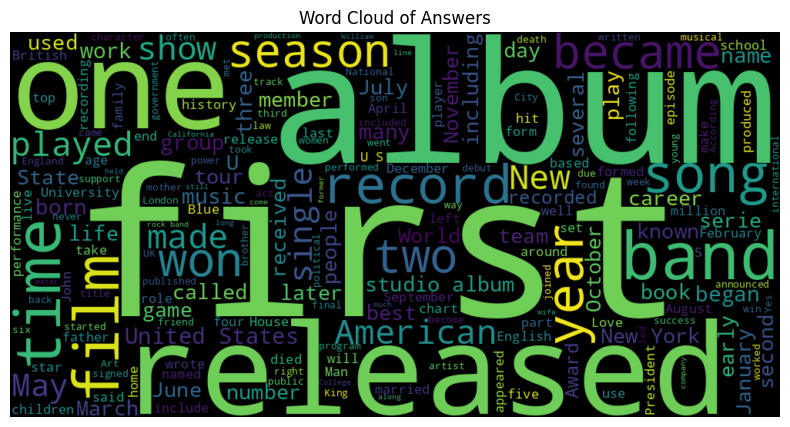

In [53]:
text = " ".join(test_data["Answer"])
plot_word_cloud(text, "Word Cloud of Answers")

# Section 2. Feature Extraction

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [11]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## 1. Tf-idf Vectorizer

In [12]:
def remove_urls(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    return text

def remove_punctuations(text):
    text = re.sub(r"[^\w\s]", '', text)
    return text

def remove_redundant_spaces(text):
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_text(text):
    text = text.lower()
    text = remove_urls(text)
    text = remove_punctuations(text)
    text = remove_redundant_spaces(text)
    return text

In [13]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return " ".join(filtered_tokens)

processed_train_question = train_data["Question"].apply(lambda x: remove_stopwords(preprocess_text(x)))
processed_test_question = test_data["Question"].apply(lambda x: remove_stopwords(preprocess_text(x)))
processed_train_answer = train_data["Answer"].apply(lambda x: remove_stopwords(preprocess_text(x)))
processed_test_answer = test_data["Answer"].apply(lambda x: remove_stopwords(preprocess_text(x)))

In [ ]:
def tfidf(train_data: pd.Series, test_data: pd.Series):
    tfidf_vectorizer = TfidfVectorizer()
    train_tfidf_matrix = tfidf_vectorizer.fit_transform(train_data)
    test_tfidf_matrix = tfidf_vectorizer.transform(test_data)
    return {"train": train_tfidf_matrix, "test": test_tfidf_matrix}

In [ ]:
question_tfidf = tfidf(processed_train_question, processed_test_question)
answer_tfidf = tfidf(processed_train_answer, processed_test_answer)

print(question_tfidf["train"].shape)
print(question_tfidf["test"].shape)
print(answer_tfidf["train"].shape)
print(answer_tfidf["test"].shape)

(63501, 16751)
(16451, 16751)
(63501, 58181)
(16451, 58181)


In [ ]:
tfidf_features_dict = {
    "question": question_tfidf,
    "answer": answer_tfidf,
}

np.savez("qrecc_tfidf_features.npz", tfidf_features_dict)

## 2. Bag of Words (BoW)


In [ ]:
def bow(train_data: pd.Series, test_data: pd.Series):
    vectorizer = CountVectorizer()
    train_bow_matrix = vectorizer.fit_transform(train_data)
    test_bow_matrix = vectorizer.transform(test_data)
    return {"train": train_bow_matrix, "test": test_bow_matrix}

In [ ]:
question_bow = bow(processed_train_question, processed_test_question)
answer_bow = bow(processed_train_answer, processed_test_answer)

print(question_bow["train"].shape)
print(question_bow["test"].shape)
print(answer_bow["train"].shape)
print(answer_bow["test"].shape)

(63501, 16751)
(16451, 16751)
(63501, 58181)
(16451, 58181)


In [ ]:
bow_features_dict = {
    "question": question_bow,
    "answer": answer_bow,
}

np.savez("qrecc_bow_features.npz", bow_features_dict)

## 3. Deep Learning
Backbone: [BAAI/bge-base-en-v1.5](https://huggingface.co/BAAI/bge-base-en-v1.5)

The **BAAI/bge-base-en-v1.5** model is an English embedding model from the Beijing Academy of Artificial Intelligence (BAAI). It's part of the BGE (BAAI General Embedding) family, designed to generate high-quality sentence embeddings for retrieval and similarity tasks.

In [54]:
model_name = "BAAI/bge-base-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [55]:
def extract_features(texts: pd.Series, batch_size: int = 64):
    features = []
    texts = texts.tolist()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True)
        inputs.to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            # Pooling strategy: use [CLS] token embedding
            batch_embeddings = outputs.last_hidden_state[:, 0, :]

        features.append(batch_embeddings.cpu())

    return torch.cat(features, dim=0)

In [56]:
train_question_features = extract_features(train_data["Question"])
train_answer_features = extract_features(train_data["Answer"])

print(train_question_features.shape)
print(train_answer_features.shape)

torch.Size([63501, 768])
torch.Size([63501, 768])


In [57]:
test_question_features = extract_features(test_data["Question"])
test_answer_features = extract_features(test_data["Answer"])

print(test_question_features.shape)
print(test_answer_features.shape)

torch.Size([16451, 768])
torch.Size([16451, 768])


In [58]:
# dl_features_dict = {
#     "question": {
#         "train": train_question_features,
#         "test": test_question_features,
#     },
#     "answer": {
#         "train": train_answer_features,
#         "test": test_answer_features,
#     },
# }

# torch.save(dl_features_dict, "qrecc_dl_features.pt")

# Analyse with Machine Learning - Question-Answer Discrimination

1. Task: Given a text segment from a conversation turn, classify whether it's a Question or an Answer.

1. Classes:
  - 0: Answer
  - 1: Question

1. Input: Embedding of the `Question` or `Answer` field from the QReCC dataset.

1. Labels: Directly derived from the column used as input.
 - If the input is from the `Question` column, the label is `1`.
 - If the input is from the `Answer` column, the label is `0`.

1. This task aims to determine if a model can learn the distinguishing linguistic features between questions and answers based on their text embeddings. It utilizes the inherent structure of QReCC, where each turn has a designated question and answer.



## 0. Build datasets

In [1]:
def build_data_with_label(question_features, answer_features, is_dl=False):
  if not is_dl:
    X = vstack([question_features, answer_features])
    y = np.concatenate([np.ones(question_features.shape[0]), np.zeros(answer_features.shape[0])])
  else:
    X = torch.cat([question_features, answer_features], dim=0)
    y = torch.cat([torch.ones(question_features.shape[0]), torch.zeros(answer_features.shape[0])], dim=0)
  return X, y

### 0.1. Traditional approaches

For Tf-idf and BoW approaches, since the task requires `Question` and `Answer` to have the same lengths, we have to **extract features again** by fitting the vectorizer from the combine corpus, then using it to transform both.

In [25]:
from scipy.sparse import load_npz, save_npz, vstack

def tfidf_updated(combine_data: list, train_data: pd.Series, test_data: pd.Series):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(combine_data)
    train_tfidf_matrix = tfidf_vectorizer.transform(train_data)
    test_tfidf_matrix = tfidf_vectorizer.transform(test_data)
    return {"train": train_tfidf_matrix, "test": test_tfidf_matrix}

def bow_updated(combine_data: list, train_data: pd.Series, test_data: pd.Series):
    vectorizer = CountVectorizer()
    vectorizer.fit(combine_data)
    train_bow_matrix = vectorizer.transform(train_data)
    test_bow_matrix = vectorizer.transform(test_data)
    return {"train": train_bow_matrix, "test": test_bow_matrix}

In [15]:
combine_data = train_data["Question"].tolist() + train_data["Answer"].tolist()
question_tfidf = tfidf_updated(combine_data, processed_train_question, processed_test_question)
question_bow = bow_updated(combine_data, processed_train_question, processed_test_question)
answer_tfidf = tfidf_updated(combine_data, processed_train_answer, processed_test_answer)
answer_bow = bow_updated(combine_data, processed_train_answer, processed_test_answer)

print(question_tfidf["train"].shape)
print(question_tfidf["test"].shape)
print(answer_tfidf["train"].shape)
print(answer_tfidf["test"].shape)

(63501, 51613)
(16451, 51613)
(63501, 51613)
(16451, 51613)


In [17]:
X_train_tfidf, y_train_tfidf = build_data_with_label(
  question_tfidf["train"],
  answer_tfidf["train"],
)
X_test_tfidf, y_test_tfidf = build_data_with_label(
  question_tfidf["test"],
  answer_tfidf["test"],
)

print("Tf-idf dataset shapes:")
print("X_train_tfidf: ", X_train_tfidf.shape)
print("y_train_tfidf: ", y_train_tfidf.shape)
print("X_test_tfidf: ", X_test_tfidf.shape)
print("y_test_tfidf: ", y_test_tfidf.shape)

Tf-idf dataset shapes:
X_train_tfidf:  (127002, 51613)
y_train_tfidf:  (127002,)
X_test_tfidf:  (32902, 51613)
y_test_tfidf:  (32902,)


In [18]:
X_train_bow, y_train_bow = build_data_with_label(
  question_bow["train"],
  answer_bow["train"],
)
X_test_bow, y_test_bow = build_data_with_label(
  question_bow["test"],
  answer_bow["test"],
)

print("BoW dataset shapes:")
print("X_train_bow: ", X_train_bow.shape)
print("y_train_bow: ", y_train_bow.shape)
print("X_test_bow: ", X_test_bow.shape)
print("y_test_bow: ", y_test_bow.shape)

BoW dataset shapes:
X_train_bow:  (127002, 51613)
y_train_bow:  (127002,)
X_test_bow:  (32902, 51613)
y_test_bow:  (32902,)


The features of Tf-idf and BoW approaches are also saved again for later use.
- X is saved using `save_npz` method from `scipy` for efficient sparse matrix saving.
- y is saved using basic `numpy.save` for numpy.array

In [27]:
save_npz("X_train_tfidf.npz", X_train_tfidf)
save_npz("X_test_tfidf.npz", X_test_tfidf)
save_npz("X_train_bow.npz", X_train_bow)
save_npz("X_test_bow.npz", X_test_bow)

np.save("y_train_tfidf.npy", y_train_tfidf)
np.save("y_test_tfidf.npy", y_test_tfidf)
np.save("y_train_bow.npy", y_train_bow)
np.save("y_test_bow.npy", y_test_bow)

### 0.2. Deep learning approach

In [59]:
X_train_dl, y_train_dl = build_data_with_label(
  train_question_features,
  train_answer_features,
  is_dl=True
)

X_test_dl, y_test_dl = build_data_with_label(
  test_question_features,
  test_answer_features,
  is_dl=True
)

print("Deep Learning shapes:")
print("X_train_dl: ", X_train_dl.shape)
print("y_train_dl: ", y_train_dl.shape)
print("X_test_dl: ", X_test_dl.shape)
print("y_test_dl: ", y_test_dl.shape)

Deep Learning shapes:
X_train_dl:  torch.Size([127002, 768])
y_train_dl:  torch.Size([127002])
X_test_dl:  torch.Size([32902, 768])
y_test_dl:  torch.Size([32902])


In [127]:
torch.save(
  {
    "X_train_dl": X_train_dl,
    "y_train_dl": y_train_dl,
    "X_test_dl": X_test_dl,
    "y_test_dl": y_test_dl
  }, "dl_features.pt"
)

## 1. Machine Learning Algorithms

### 1.1. Define model classes

In [29]:
from copy import deepcopy

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

In [46]:
class BaseModel:
  def __init__(self):
    self.model = None

  def fit(self, X, y):
    self.model.fit(X, y)
    return self

  def predict(self, X):
    return self.model.predict(X)

  def eval(self, X, y):
    y_pred = self.predict(X)
    report = classification_report(y, y_pred, output_dict=True)

    results = {
        "accuracy": report["accuracy"],
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1-score": report["macro avg"]["f1-score"]
    }
    return results

  def accuracy(self, X, y):
    y_pred = self.predict(X)
    return accuracy_score(y, y_pred)

  def classification_report(self, X, y):
    y_pred = self.predict(X)
    return classification_report(y, y_pred, output_dict=True)

  def __repr__(self):
    return self.model.__repr__()

class LogisticRegressionn(BaseModel):
  def __init__(self):
    self.model = LogisticRegression()

class NaiveBayes(BaseModel):
  def __init__(self):
    self.model = MultinomialNB()

class SVM(BaseModel):
  def __init__(self):
    self.model = LinearSVC()

In [47]:
ml_models = [LogisticRegressionn(), NaiveBayes(), SVM()]
ml_models

[LogisticRegression(), MultinomialNB(), LinearSVC()]

### 1.2. Train models

In [48]:
trained_models_tfidf = [model.fit(X_train_tfidf, y_train_tfidf) for model in deepcopy(ml_models)]
trained_models_bow = [model.fit(X_train_bow, y_train_bow) for model in deepcopy(ml_models)]

### 1.3. Evaluate the trained models

In [49]:
eval_tfidf_results = [model.eval(X_test_tfidf, y_test_tfidf) for model in trained_models_tfidf]
eval_bow_results = [model.eval(X_test_bow, y_test_bow) for model in trained_models_bow]

In [146]:
# TODO: export results and visualize accuracy, precision, recall, f1-score (class 0, class 1, macro avg)
def visualize_results(results, model_names):
  df = pd.DataFrame(results)
  df["model"] = model_names
  df = df.set_index("model")

  ax = df.T.plot(kind="line", marker="o")
  plt.title("Performance Metrics of Different Models")
  plt.ylabel("Score")
  plt.legend(title="models")

  # Add data labels to each point
  # for line in ax.lines:
  #     for x, y in zip(line.get_xdata(), line.get_ydata()):
  #         ax.annotate(f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0, 10), ha="center")

  plt.show()

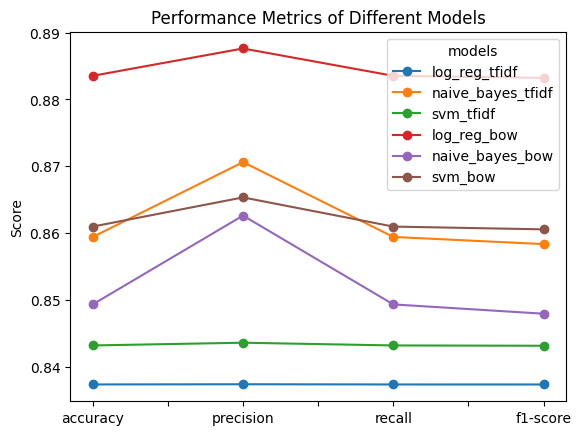

In [94]:
model_names = [
  "log_reg_tfidf",
  "naive_bayes_tfidf",
  "svm_tfidf",
  "log_reg_bow",
  "naive_bayes_bow",
  "svm_bow"
]

visualize_results(eval_tfidf_results + eval_bow_results, model_names)

- The overall best model is `Logistic Regression` using `Bag of Words` features
- While the best model using `Td-idf` ones is `Naive Bayes`
- These two models are used to predict some samples in the next section

### 1.4. Predict and show the results for some samples

In [103]:
combine_test_data = test_data["Question"] + test_data["Answer"]
combine_test_data.head()

,0
0,What is a physician's assistant?physician assi...
1,What are the educational requirements required...
2,What does it cost?Average Cost Across all PA S...
3,What's the average starting salary in the UK?T...
4,What about in the US?An early career Physician...


In [116]:
def sample_data(test_data, features, labels, sampled_indices):
  sampled_data = test_data[sampled_indices]
  sampled_features = features[sampled_indices, :]
  sampled_labels = labels[sampled_indices]

  return sampled_data, sampled_features, sampled_labels

def log_prediction(sampled_data: tuple, model: BaseModel):
  id2label = {0: "Question", 1: "Answer"}
  preds = model.predict(sampled_data[1])

  for data, pred, label in zip(sampled_data[0], preds, sampled_data[2]):
    print("{:>5}: {}".format("Input", data))
    print("{:>5}: {}".format("Pred", id2label[pred]))
    print("{:>5}: {}".format("Label", id2label[label]))
    print()

In [115]:
sampled_indices = np.random.choice(len(test_data), size=10, replace=False)
best_models = {
    "tfidf": trained_models_tfidf[1],
    "bow": trained_models_bow[0]
}
print("Best model of each approach: ", best_models)

Best model of each approach:  {'tfidf': MultinomialNB(), 'bow': LogisticRegression()}


In [117]:
print("Prediction using Naive Bayes model with Tf-idf features:")
print("-"*50)

sampled_data_tfidf = sample_data(combine_test_data, X_test_tfidf, y_test_tfidf, sampled_indices)
log_prediction(sampled_data_tfidf, best_models["tfidf"])

Prediction using Naive Bayes model with Tf-idf features:
--------------------------------------------------
Input: What was she doing that she was noticed?
 Pred: Answer
Label: Answer

Input: What happened?On January 3, 2013 Bleeding Through announced their upcoming tour in Europe would be their last, leading to rumors that the band would be breaking up.
 Pred: Answer
Label: Answer

Input: Did the band tour for this album?The Born Again Tour 1983 was a global concert tour in support of Black Sabbath's Born Again album. Drummer Bev Bevan was hired to replace Bill Ward.
 Pred: Answer
Label: Answer

Input: When was the single released?the album's first single Bigger than Us was released on 3 January 2011.
 Pred: Answer
Label: Answer

Input: where is the majority foundWater is found mostly in the cytosol of human cells.
 Pred: Question
Label: Answer

Input: What is worth seeing in Washington DCMost prominent at its center point is the Washington Monument, and war memorials include those to

In [119]:
print("Prediction using Logistic Regression model with Bag of Words features:")
print("-"*50)

sampled_data_bow = sample_data(combine_test_data, X_test_bow, y_test_bow, sampled_indices)
log_prediction(sampled_data_bow, best_models["bow"])

Prediction using Logistic Regression model with Bag of Words features:
--------------------------------------------------
Input: What was she doing that she was noticed?
 Pred: Answer
Label: Answer

Input: What happened?On January 3, 2013 Bleeding Through announced their upcoming tour in Europe would be their last, leading to rumors that the band would be breaking up.
 Pred: Answer
Label: Answer

Input: Did the band tour for this album?The Born Again Tour 1983 was a global concert tour in support of Black Sabbath's Born Again album. Drummer Bev Bevan was hired to replace Bill Ward.
 Pred: Answer
Label: Answer

Input: When was the single released?the album's first single Bigger than Us was released on 3 January 2011.
 Pred: Answer
Label: Answer

Input: where is the majority foundWater is found mostly in the cytosol of human cells.
 Pred: Question
Label: Answer

Input: What is worth seeing in Washington DCMost prominent at its center point is the Washington Monument, and war memorials in

## 2. Deep Learning

### 2.1. Define model class and data loader

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from sklearn.metrics import classification_report

In [132]:
class CNN1DClassifier(nn.Module):
    def __init__(self, kernel_size=3, padding=1, pool_size=2):
        super(CNN1DClassifier, self).__init__()

        self.conv1 = nn.Conv1d(1, 256, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=pool_size)

        self.conv2 = nn.Conv1d(256, 128, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=pool_size)

        self.conv3 = nn.Conv1d(128, 64, kernel_size=kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=pool_size)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 96, 64)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        self.criterion = nn.BCELoss()

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

    def train_model(self, train_loader, optimizer, num_epochs=10):
        print("Train with {} device".format(self.device))

        self.train()
        for epoch in range(num_epochs):
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                optimizer.zero_grad()
                outputs = self(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    def evaluate_model(self, test_loader):
        self.eval()
        y_true = []
        y_pred = []

        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(self.device)
                outputs = self(batch_X)
                predicted = (outputs > 0.5).float()
                y_pred.extend(predicted)

                batch_y = batch_y.cpu().numpy().item()
                y_true.extend(batch_y)

                print("y_true: ", y_true)
                print("y_pred: ", y_pred)

            report = classification_report(y_true, y_pred, output_dict=True)

            results = {
                "accuracy": report["accuracy"],
                "precision": report["macro avg"]["precision"],
                "recall": report["macro avg"]["recall"],
                "f1-score": report["macro avg"]["f1-score"]
            }

        return results

In [133]:
def prepare_data_loaders(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, batch_size=64):
    X_train_tensor = X_train_tensor.unsqueeze(1)
    X_test_tensor = X_test_tensor.unsqueeze(1)

    y_train_tensor = y_train_tensor.float().view(-1, 1)
    y_test_tensor = y_test_tensor.float().view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [138]:
batch_sie = 512
train_loader, test_loader = prepare_data_loaders(
    X_train_dl, y_train_dl, X_test_dl, y_test_dl, batch_sie
)

print("Train loader length: ", len(train_loader))
print("Test loader length: ", len(test_loader))

Train loader length:  249
Test loader length:  65


In [139]:
print("Check data shape when loading: ")

for batch_X, batch_y in train_loader:
  print("batch_X.shape: ", batch_X.shape)
  print("batch_y.shape: ", batch_y.shape)
  break

Check data shape when loading: 
batch_X.shape:  torch.Size([512, 1, 768])
batch_y.shape:  torch.Size([512, 1])


### 2.2. Train model

Define hyper-parameters for training model

In [140]:
num_epochs = 100
learning_rate = 0.001

model = CNN1DClassifier()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [141]:
model.train_model(train_loader, optimizer, num_epochs)

Train with cuda device
Epoch 1/100, Loss: 0.2330
Epoch 2/100, Loss: 0.2701
Epoch 3/100, Loss: 0.2379
Epoch 4/100, Loss: 0.1929
Epoch 5/100, Loss: 0.1486
Epoch 6/100, Loss: 0.2084
Epoch 7/100, Loss: 0.1378
Epoch 8/100, Loss: 0.0920
Epoch 9/100, Loss: 0.1198
Epoch 10/100, Loss: 0.0577
Epoch 11/100, Loss: 0.0354
Epoch 12/100, Loss: 0.0552
Epoch 13/100, Loss: 0.0860
Epoch 14/100, Loss: 0.0387
Epoch 15/100, Loss: 0.0428
Epoch 16/100, Loss: 0.0298
Epoch 17/100, Loss: 0.0342
Epoch 18/100, Loss: 0.0238
Epoch 19/100, Loss: 0.0326
Epoch 20/100, Loss: 0.0245
Epoch 21/100, Loss: 0.0202
Epoch 22/100, Loss: 0.0145
Epoch 23/100, Loss: 0.1488
Epoch 24/100, Loss: 0.0168
Epoch 25/100, Loss: 0.0151
Epoch 26/100, Loss: 0.0163
Epoch 27/100, Loss: 0.0106
Epoch 28/100, Loss: 0.1627
Epoch 29/100, Loss: 0.0055
Epoch 30/100, Loss: 0.0085
Epoch 31/100, Loss: 0.0061
Epoch 32/100, Loss: 0.0066
Epoch 33/100, Loss: 0.0060
Epoch 34/100, Loss: 0.0067
Epoch 35/100, Loss: 0.0061
Epoch 36/100, Loss: 0.0198
Epoch 37/100, 

In [142]:
torch.save(model.state_dict(), "cnn_1d_classifier.pt")

### 2.3. Evaluate the trained model

In [148]:
eval_results = model.evaluate_model(test_loader)
eval_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.5,
 'precision': 0.25,
 'recall': 0.5,
 'f1-score': 0.3333333333333333}

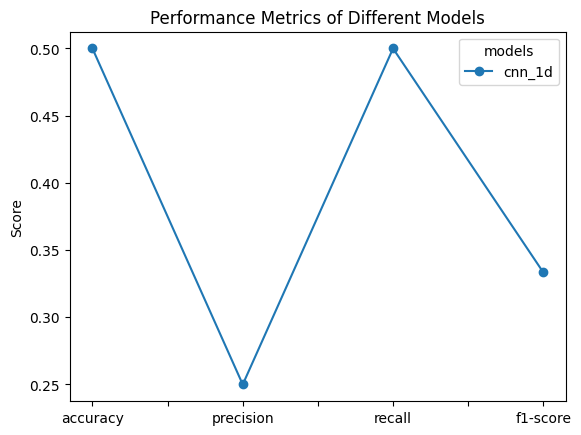

In [147]:
visualize_results([eval_results], ["cnn_1d"])

### 2.4. Predict and show the results for some samples

In [149]:
combine_test_data = test_data["Question"] + test_data["Answer"]
combine_test_data.head()

,0
0,What is a physician's assistant?physician assistants are medical providers who are licensed to diagnose and treat illness and disease and to prescribe medication for patients
1,"What are the educational requirements required to become one?Complete your bachelor's degree (a science or healthcare related major is usually best); Gain experience either working or volunteering in a healthcare setting; Apply to ARC-PA accredited physician assistant programs; Complete a 2-3 year, master's level PA program;"
2,"What does it cost?Average Cost Across all PA Schools for the 2017 Application Cycle is as Follows: Average cost of resident tuition for a 27-month physician assistant program is: $71,369. Average cost of non-resident tuition for a 27-month physician assistant program is: $89,975."
3,"What's the average starting salary in the UK?Typical starting salaries for physician associates are between £27,000 and £31,383 (though sometimes less for internships)."
4,"What about in the US?An early career Physician Assistant (PA) with 1-4 years of experience earns an average total compensation (includes tips, bonus, and overtime pay) of $91,587 based on 4,392 salaries."


In [157]:
def sample_data_dl(test_data, features, labels, sampled_indices):
  sampled_data = test_data[sampled_indices]
  sampled_features = features[sampled_indices, :].unsqueeze(1)
  sampled_labels = labels[sampled_indices]

  return sampled_data, sampled_features, sampled_labels

def log_prediction_dl(sampled_data: tuple, model: nn.Module):
  id2label = {0: "Question", 1: "Answer"}
  model.eval()
  with torch.no_grad():
    y_pred = model(sampled_data[1].to(model.device))

  for data, pred, label in zip(sampled_data[0], y_pred, sampled_data[2]):
    pred = pred.cpu().item()
    label = label.cpu().item()

    print("{:>5}: {}".format("Input", data))
    print("{:>5}: {}".format("Pred", id2label[pred]))
    print("{:>5}: {}".format("Label", id2label[label]))
    print()

In [158]:
sampled_indices = np.random.choice(len(test_data), size=10, replace=False)
model = CNN1DClassifier()
model.load_state_dict(torch.load("cnn_1d_classifier.pt", weights_only=True))
model.to(model.device)
print("Model deep learning: ", model)

Model deep learning:  CNN1DClassifier(
  (conv1): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6144, out_features=64, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=64, out

In [159]:
print("Prediction using deep learning model:")
print("-"*50)

sampled_data_dl = sample_data_dl(combine_test_data, X_test_dl, y_test_dl, sampled_indices)
log_prediction_dl(sampled_data_dl, model)

Prediction using deep learning model:
--------------------------------------------------
Input: Did the Olmecs separate themselves by classes?The elite class created the demand for the production of the symbolic and sophisticated luxury artifacts that define Olmec culture.


KeyError: 0.9999992847442627